# Bayesian Exam 2024R
**Lucas Pedersen, s203768**

In [171]:
import jax.numpy as jnp
import matplotlib.pylab as plt
import seaborn as snb
from jax import random
from jax import jit
from jax.scipy.special import logsumexp
from jax import grad
from jax import hessian
from jax.flatten_util import ravel_pytree


# style stuff
snb.set_style('darkgrid')
snb.set_theme(font_scale=1.5)

## Part 1: Multi-class classification

### Q1.1 - Identify prior and likelihood

**prior**
Is given as
$$ p(\mathbf{W}) = \mathcal{mN} (0, \alpha^{-1}) $$

**likelihood**
Is given as
$$ p(\mathbf{y} | \mathbf{W}) = Cat(\text{softmax}\left(\mathbf{W} \phi \left(\mathbf{x}\right)\right))  $$

### Q1.2 - Plugin approximation

In [172]:
softmax = lambda x: jnp.exp(x) / (jnp.sum(jnp.exp(x), axis = 0))
W_map = jnp.array([[-0.5, -2.], [3., 0.], [1., 1.]])

def create_matrx(x):
    return jnp.concat((jnp.ones_like(x), x), axis = 1)

X = jnp.array([1,-1])
f = W_map @ X.T
print(f)
print(f'Probability distribution for x_star = -1: {softmax(f)}')
# print(f"Probability of x = 1: {softmax(f)[0]:.3f}")


[1.5 3.  0. ]
Probability distribution for x_star = -1: [0.17529039 0.785597   0.03911257]


### Q1.3 - Montecarlo estimate

In [173]:
W1 = jnp.array([[-0.15, -1.92], [3.2, 0.45], [1.37, 0.80]]) 
W2 = jnp.array([[-0.31, -2.03], [2.98, 0.08], [1.03, 1.29]]) 
W3 = jnp.array([[-0.35, -1.98], [3.09, 0.07], [1.3, 0.96]])
Ws = [W1, W2, W3]

X = jnp.array([1,-1])
ps = jnp.zeros(shape = (3,))
for W in Ws:
    f = W @ X.T
    ps += softmax(f)

print(ps / 3)

[0.2229536  0.72390676 0.05313967]


### Q1.4

Confidence is just the max, so this is $0.73$

The entropy actually must be computed, since one probability is given as $ 0 $, this will output Nan. We can add a small constant to all probabilities to avoid this

In [174]:
pis = jnp.array([0.00, 0.27, 0.73])
print(f"The entropy is :{-jnp.sum(pis * jnp.log(pis))}")

print(f"The entropy (when adding a small constant) is :{-jnp.sum((pis + 1e-10) * jnp.log(pis + 1e-10))}")

The entropy is :nan
The entropy (when adding a small constant) is :0.583258867263794


### Q1.5 - Scailing of $ \alpha $

$ \alpha $ is the variance of the prior and $ \alpha^{-1} $ is the precission. If we scale $ \alpha $ by a factor of $ 10 $ the precission is lowered by a factor of $ 10 $, suggesting that we trust our data less, and instead weigh the prior higher. We would expect the predictive distribution to shift more towards a uniform distribution.

## Part 2

In [175]:
x = jnp.array([-2., 0., 2.])
y = jnp.array([-2.01, 1.41, 0.23])

### Q2.1 - Magnitude and lengthscale of GP

The squared exponential kernel is 

$$ \kappa ^2 \exp \left(\frac{d^2}{-2l^2}\right) $$

So the magnitude is 
$$ \kappa = \sqrt{2} $$

and the lenghtscale is 

$$ l = 2 $$

### Q2.2 - Analytical distribution of f in GP

From the definition

$$ p(\mathbf{f}|{x})  = \mathcal(0, \mathbf{K})$$

where $$ K_{nm} = k(x_n, x_m) $$
where $ k $ is the given squared exponential kernel

In [176]:
def squared_exp(xn, xm, l = 2, kappa = jnp.sqrt(2)):
    return kappa**2 * jnp.exp((xn - xm)**2/ (-2 * l**2)) 

K = jnp.zeros(shape = (3,3))
for i in range(len(x)):
    for j in range(len(x)):
        K = K.at[i,j].set(squared_exp(x[i], x[j]))

print(f"The kernel is:")
print(K)


The kernel is:
[[1.9999999  1.2130612  0.27067053]
 [1.2130612  1.9999999  1.2130612 ]
 [0.27067053 1.2130612  1.9999999 ]]


### Q2.3 - Posterior of analytical distribution of f in GP

From the Murphy1 equations 17.34 - 17.36
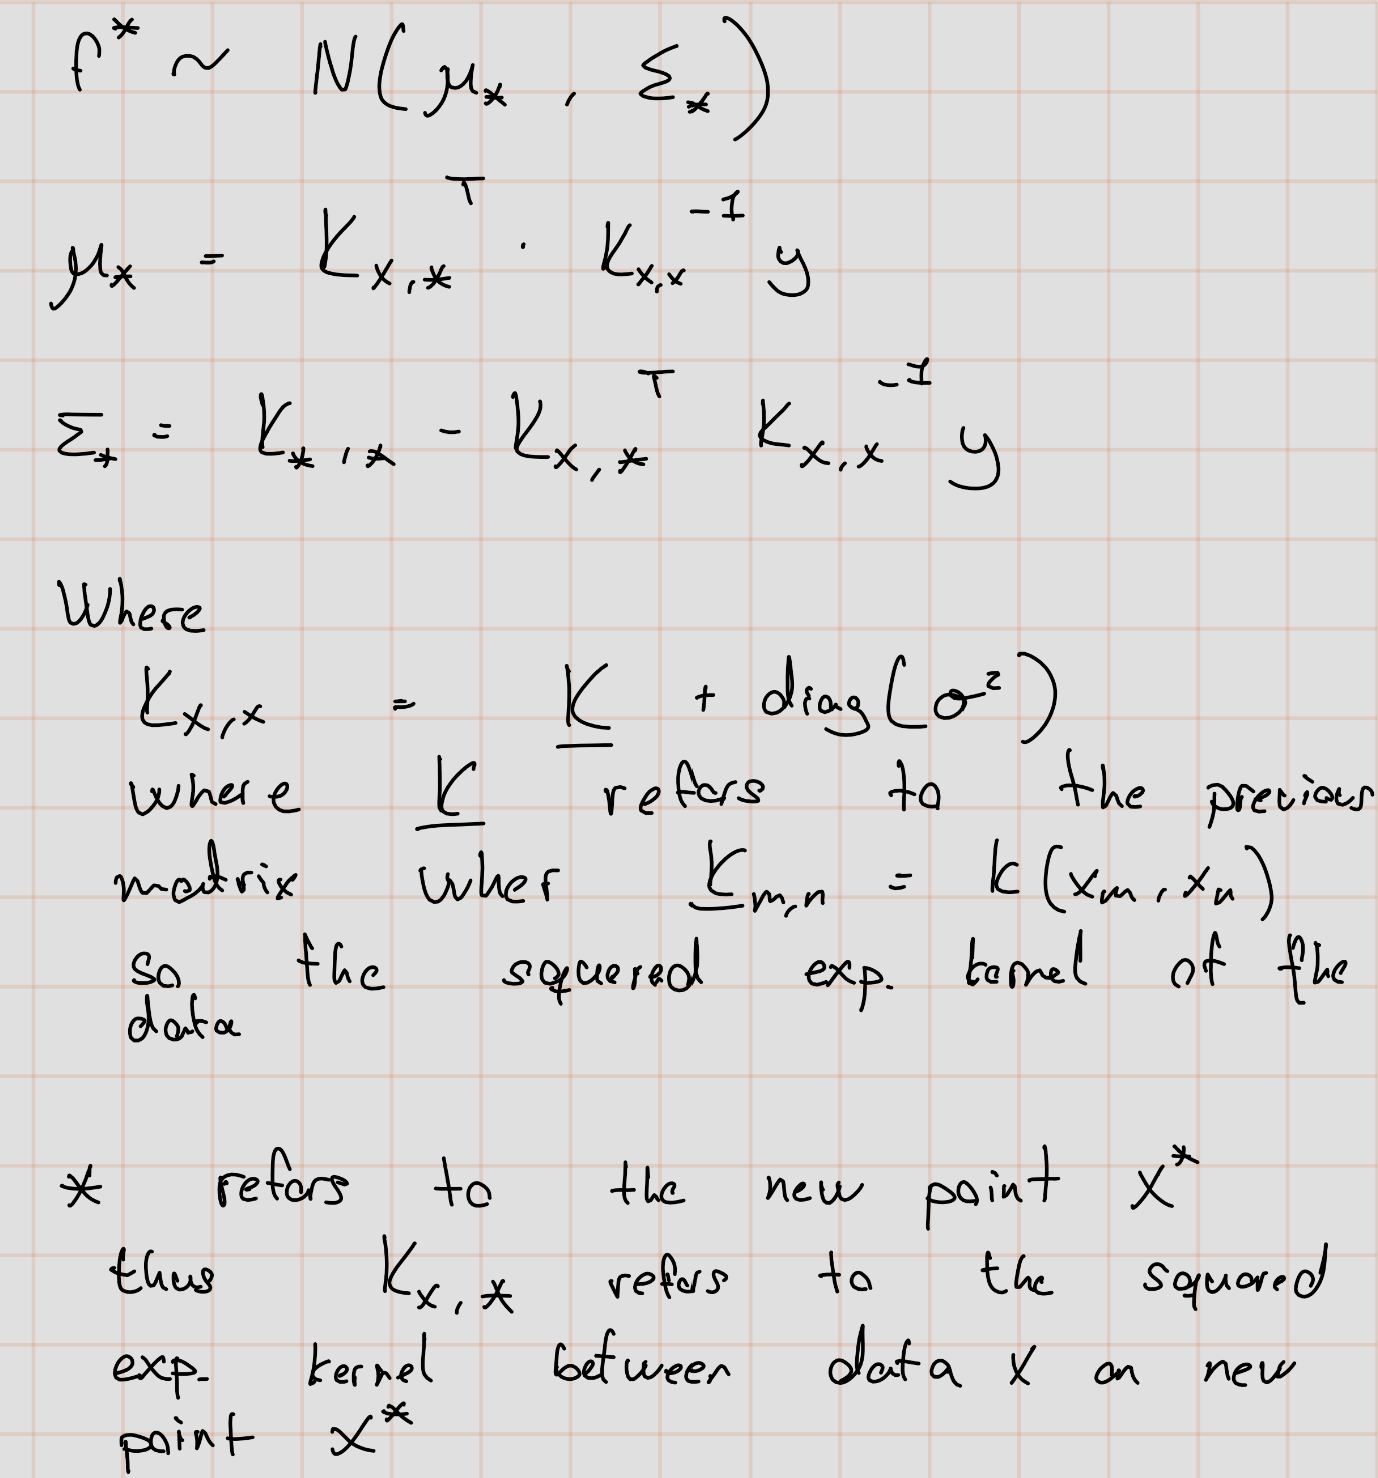

In [177]:
sigsq = 0.5**2
N = 3
Kxx = K + jnp.identity(N) * sigsq

mu = K.T @ jnp.linalg.solve(Kxx, y.T)

sigma = K - K.T @ jnp.linalg.solve(Kxx, K)
print(mu)
print(sigma)

[-1.5283369   0.8865025   0.42873892]
[[ 0.20844185  0.02778709 -0.00998175]
 [ 0.02778697  0.19226015  0.02778709]
 [-0.00998178  0.02778709  0.20844197]]


### Q2.4
Again 

$$ f \sim \mathcal(N)\left(0, K\right) $$
but now the way of finding $ K $ has changed

In [178]:
def new_kernel(xm, xn):
    return jnp.exp(-jnp.abs(xm - xn) * 0.5) + 2

K = jnp.zeros(shape = (3,3))
for i in range(len(x)):
    for j in range(len(x)):
        K = K.at[i,j].set(new_kernel(x[i], x[j]))

print(f"The new kernel is:")
print(K)


The new kernel is:
[[3.        2.3678794 2.1353352]
 [2.3678794 3.        2.3678794]
 [2.1353352 2.3678794 3.       ]]


## Part 3

In [179]:
log_npdf = lambda x, m, v: -(x-m)**2/(2*v) - 0.5*jnp.log(2*jnp.pi*v)
npdf = lambda x, m, v: jnp.exp(log_npdf(x,m,v))
from scipy.stats import multivariate_normal as mv
from scipy.optimize import minimize

v = jnp.identity(2)
m = jnp.ones(shape = (2,))
y = jnp.array([1,0])
W = jnp.array([[1, 0.5], [-1, 1]])
def fun(theta):
    return -(jnp.log(0.5 * mv.pdf(x = theta, mean = m, cov = v) + 0.5 * mv.pdf(x = theta, mean = -m, cov = v)) + mv.logpdf(x = y, mean = W @ theta.T, cov = v))

nu0 = jnp.array([0,0])

res = minimize(fun, nu0, method='nelder-mead', options={'xatol': 1e-8, 'disp': True})

print(res)

Optimization terminated successfully.
         Current function value: 4.387867
         Iterations: 69
         Function evaluations: 166
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 4.387866973876953
             x: [ 7.732e-01  8.017e-01]
           nit: 69
          nfev: 166
 final_simplex: (array([[ 7.732e-01,  8.017e-01],
                       [ 7.732e-01,  8.017e-01],
                       [ 7.732e-01,  8.017e-01]]), array([ 4.388e+00,  4.388e+00,  4.388e+00]))


### Q3.2 - Value of prior

In [180]:
def prior(theta):
    return 0.5 * mv.pdf(x = theta, mean = m, cov = v) + 0.5 * mv.pdf(x = theta, mean = -m, cov = v)

print(prior(jnp.array([0,0])))

0.05854983152431917


### Q3.3 - Marginal likelihood

$$ p(y | theta) $$

In [181]:
theta_map = res.x
mu = W @ theta_map
print(mu)

print(f"Value of marginal likelihood: {mv.pdf(x = y, mean = mu)}")


[1.174094   0.02851784]
Value of marginal likelihood: 0.1566975046966882


$$ p(\mathbf{y} | \mathbf{\theta}) = \mathcal{N}\left(\mu , \Sigma \right) $$

where $ \mu = [1.174094 \    0.02851784] $ and $ \Sigma = \mathbf{I} $

### Q3.4 - Value of posterior

In [182]:
py = mv.pdf(x = y, mean = mu)
theta = jnp.array([0,0])
print(f"value of posterior density: {jnp.exp(-fun(theta)) / py}")

value of posterior density: 0.036069199442863464


## Part 4

### Q4.1
From visual inspection:

$$ w_1 \approx -0.5 \qquad w_2 \approx -0.2 $$

### Q4.2
Inserting $ x^*= 0 $

$$ \mu(0) = \exp(3) $$

In [183]:
precission = 8**-1
from scipy.stats import poisson
def log_posterior(w):
    w1 = w[0]
    w2 = w[1]

    log_prior = log_npdf(w1, 0, precission) + log_npdf(w2, 0, precission)

    mus = jnp.exp(3 + w1 * x + w2 * x**2)

    log_like = poisson.logpmf(y, mus)

    return log_prior + jnp.sum(log_like)


w0 = jnp.array([0,0])
x = jnp.array([1,2,3])
y = jnp.array([10,4,1])
tau = 1

num_iter = 10000



In [184]:
def metropolis(log_target, num_params, tau, num_iter, theta_init=None, seed=0):    
    """ Runs a Metropolis-Hastings sampler 
    
        Arguments:
        log_target:         function for evaluating the log target distribution, i.e. log \tilde{p}(theta). The function expect a parameter of size num_params.
        num_params:         number of parameters of the joint distribution (integer)
        tau:                standard deviation of the Gaussian proposal distribution (positive real)
        num_iter:           number of iterations (integer)
        theta_init:         vector of initial parameters (jnp.array with shape (num_params) or None)        
        seed:               seed (integer)

        returns
        thetas              jnp.array with MCMC samples (jnp.array with shape (num_iter+1, num_params))
    """ 
    
    # set initial key
    key = random.PRNGKey(seed)

    if theta_init is None:
        theta_init = jnp.zeros((num_params))
    
    # prepare lists 
    thetas = [theta_init]
    accepts = []
    log_p_theta = log_target(theta_init)
    
    for k in range(num_iter):

        # update keys: key_proposal for sampling proposal distribution and key_accept for deciding whether to accept or reject.
        key, key_proposal, key_accept = random.split(key, num=3)

        # get the last value for theta and generate new proposal candidate
        theta_cur = thetas[-1]
        theta_star = theta_cur + tau*random.normal(key_proposal, shape=(num_params, ))
        
        # evaluate the log density for the candidate sample
        log_p_theta_star = log_target(theta_star)

        # compute acceptance probability
        log_r = log_p_theta_star - log_p_theta
        A = min(1, jnp.exp(log_r))
        
        # accept new candidate with probability A
        if random.uniform(key_accept) < A:
            theta_next = theta_star
            log_p_theta = log_p_theta_star
            accepts.append(1)
        else:
            theta_next = theta_cur
            accepts.append(0)

        thetas.append(theta_next)


        
    print('Acceptance ratio: %3.2f' % jnp.mean(jnp.array(accepts)))
        
    # return as jnp.array
    thetas = jnp.stack(thetas)

    # check dimensions and return
    assert thetas.shape == (num_iter+1, num_params), f'The shape of thetas was expected to be ({num_iter+1}, {num_params}), but the actual shape was {thetas.shape}. Please check your code.'
    return thetas, accepts

Acceptance ratio: 0.04


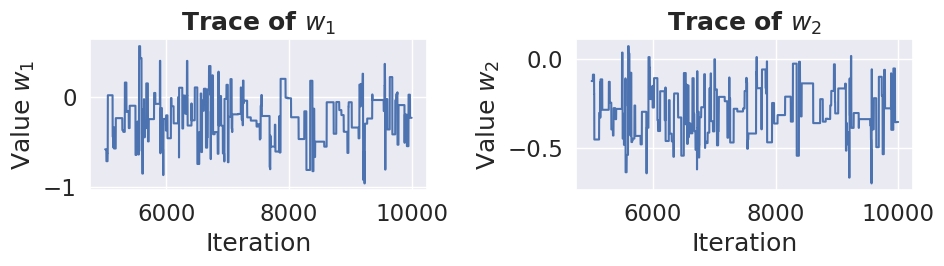

In [185]:
w_samples, accept = metropolis(log_posterior, 2, tau, 10000, w0, seed = 0)
w_samples = w_samples
def plot_traces(thetas, axis1, axis2, x_start, x_end,  labels):

    num_params = thetas.shape[1]
    fig, axes = plt.subplots(axis1, axis2, figsize=(5 * axis2, 3 * axis1))
    axes = axes.flatten()  # Flatten in case axes is 2D

    for i in range(num_params):
        theta = thetas[:,i]
        axes[i].plot(range(x_start, x_end+1), theta[x_start:])
        axes[i].set_xlabel('Iteration')
        axes[i].set_ylabel(f'Value {labels[i]}')
        axes[i].set_title(f'Trace of {labels[i]}', fontweight='bold')

    # Hide any unused subplots
    for j in range(num_params, axis1 * axis2):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

labels = ['$w_1$', '$w_2$']
plot_traces(w_samples, 1, 2, 5000, 10000, labels)

### Q4.4 - Probability of w1 positive

In [186]:
ws = w_samples[5000:, :]

print(f"Probability of w1 positive {jnp.mean(ws[:,0] > 0):.2f}")

Probability of w1 positive 0.16


### Q4.5 - Probability of mu

In [187]:
xstar = 1.5
mus = jnp.exp(3 + ws[:,0] * xstar + ws[:,1] * xstar**2)

print(f"Probability of mu(xstar) > 7: {jnp.mean(mus > 7):.2f}")

Probability of mu(xstar) > 7: 0.65


### Q4.6 - Credibility of posterior

In [188]:
y_samples = poisson.rvs(mus)
print(jnp.quantile(a = y_samples, q = jnp.array([0.05, 0.95]) ))

[ 3. 13.]


## Part 5:

### Q 5.1 - Ancestral sampling

In [189]:
S = 1000

key = random.key(seed = 0)
key_w, key_y = random.split(key, 2)
ws = random.normal(key_w, shape=S)
ys = random.normal(key_y, shape = S) + jnp.exp(ws)

print(f"Prior mean of y: {jnp.mean(jnp.exp(ws)):.3f}")


Prior mean of y: 1.564


### Q5.2 - Joint dist

In [ ]:
w_map = 1.293404
y = 5
def log_joint(w):
    log_prior = log_npdf(x = w, m = 0, v = 1)
    log_lik = log_npdf(x = y, m = jnp.exp(w), v = 1)

    return log_prior + log_lik

print(f"log joint for y = 1: {log_joint(w_map):.3f}")

log joint for y = 1: -3.592


### Q5.3 Laplace

In [220]:
joint = lambda w: jnp.exp(log_joint(w))

log_joint = lambda w: log_npdf(x = w, m = 0, v = 1) + log_npdf(x = y, m = jnp.exp(w), v = 1)

hes = hessian(log_joint, 0)
var = -(1/hes(w_map))

print(f"Mean of laplace: {w_map:.3f}")
print(f"Variance of laplace: {var}")


def theo_hes(w):
    return y * jnp.exp(w) - 2 * jnp.exp(2 * w) - 1

print(theo_hes(w_map))
print(hes(w_map))

Mean of laplace: 1.293
Variance of laplace: 0.10696659982204437
-9.348713
-9.348713
